In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActiveAttentionModule(nn.Module):
    def __init__(self, F_l_channels, F_h_channels, F_int_channels):
        super(ActiveAttentionModule, self).__init__()
        
        # CHANGED: Conv3d -> Conv2d for images
        self.W_l = nn.Sequential(
            nn.Conv2d(F_l_channels, F_int_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int_channels)
        )
        self.W_h = nn.Sequential(
            nn.Conv2d(F_h_channels, F_int_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int_channels)
        )
        self.W_s = nn.Sequential(
            nn.Conv2d(F_int_channels, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, F_l, F_h):
        g_h = self.W_h(F_h)
        g_l = self.W_l(F_l)
        
        # Resize if dimensions don't match (using bilinear for 2D)
        if g_h.shape[2:] != g_l.shape[2:]:
            g_h = F.interpolate(g_h, size=g_l.shape[2:], mode='bilinear', align_corners=True)
        
        psi = self.relu(g_l + g_h)
        attention_map = self.W_s(psi)
        return F_l * attention_map, attention_map # filtered features,useful for visualization/debugging

class ConvBlock2D(nn.Module): #Extract local features from seismic slices.
    def __init__(self, in_ch, out_ch):
        super(ConvBlock2D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class SeismicAttentionUNet2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SeismicAttentionUNet2D, self).__init__()
        
        # Encoder (2D)
        self.enc1 = ConvBlock2D(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock2D(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock2D(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ConvBlock2D(128, 256)
        
        # Attention Modules
        self.aam3 = ActiveAttentionModule(128, 256, 64)
        self.aam2 = ActiveAttentionModule(64, 128, 32)
        self.aam1 = ActiveAttentionModule(32, 64, 16)
        
        # Decoder (Upsampling 2D)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = ConvBlock2D(256 + 128, 128) 
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = ConvBlock2D(128 + 64, 64)
        
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = ConvBlock2D(64 + 32, 32)
        
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        
        b_up = self.up3(b)
        e3_filtered, attn3 = self.aam3(e3, b_up)
        d3 = self.dec3(torch.cat([b_up, e3_filtered], dim=1))
        
        d3_up = self.up2(d3)
        e2_filtered, attn2 = self.aam2(e2, d3_up)
        d2 = self.dec2(torch.cat([d3_up, e2_filtered], dim=1))
        
        d2_up = self.up1(d2)
        e1_filtered, attn1 = self.aam1(e1, d2_up)
        d1 = self.dec1(torch.cat([d2_up, e1_filtered], dim=1))
        
        return self.final_conv(d1), [attn1, attn2, attn3]

In [156]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
class SeismicDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir)) # Ensure matching order
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load Image (Greyscale)
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- CHANGE 1: Apply Vertical Sobel Filter (Cleaning the input) ---
        # This highlights faults and removes horizontal layers BEFORE the AI sees it
        sobel_x = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, ksize=3)
        abs_sobel = np.absolute(sobel_x)
        # Normalize back to 0-255 uint8
        image = np.uint8(255 * abs_sobel / (np.max(abs_sobel) + 1e-6))
        
        # Resize to 128x128 for training (Standard U-Net size)
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        # --- CHANGE 2: Data Augmentation (Horizontal Flip) ---
        # 50% chance to flip the image left-to-right. 
        # This effectively doubles your dataset size.
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
        
        # Normalize (0 to 1)
        image = image / 255.0
        mask = mask / 255.0
        
        # Add Channel Dimension [H, W] -> [1, H, W]
        image = np.expand_dims(image, axis=0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        
        # Create Gaussian Target for Deep Supervision (Optional but recommended)
        # We blur the mask to create a "heat map" for the attention layer
        gaussian_target = cv2.GaussianBlur(mask[0], (5, 5), 0)
        gaussian_target = np.expand_dims(gaussian_target, axis=0).astype(np.float32)

        return {
            'image': torch.from_numpy(image),
            'mask': torch.from_numpy(mask),
            'gaussian': torch.from_numpy(gaussian_target)
        }

# --- Initialize ---
dataset = SeismicDataset("dataset_final/images", "dataset_final/masks")
loader = DataLoader(dataset, batch_size=8, shuffle=True)

print(f"Data Ready! Found {len(dataset)} images.")

import torch
import torch.nn as nn
import torch.nn.functional as F

class SeismicSparseLoss(nn.Module):
    def __init__(self, lambda_smooth=1.0):
        super(SeismicSparseLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none') 
        self.smooth_l1 = nn.SmoothL1Loss(reduction='mean')
        self.lambda_smooth = lambda_smooth

    def forward(self, logits, attention_maps, targets, label_weights, gaussian_targets):
        
        # 1. Main Segmentation Loss
        loss_bce_pixel = self.bce(logits, targets)
        loss_bce = (loss_bce_pixel * label_weights).sum() / (label_weights.sum() + 1e-6)
        
        # 2. Attention Loss (Fixed for 2D)
        loss_att = 0
        for attn_map in attention_maps:
            # changed 'trilinear' -> 'bilinear'
            target_resized = F.interpolate(gaussian_targets, size=attn_map.shape[2:], mode='bilinear', align_corners=True)
            loss_att += self.smooth_l1(attn_map, target_resized)
            
        total_loss = loss_bce + (self.lambda_smooth * loss_att)
        
        return total_loss, loss_bce, loss_att

Data Ready! Found 185 images.


In [157]:
import torch.optim as optim

# Re-initialize to apply the fix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SeismicAttentionUNet2D().to(device)
criterion = SeismicSparseLoss(lambda_smooth=2.0).to(device) # <--- Uses the fixed class now
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 25 
print(f"Starting Training on {device}...")

for epoch in range(num_epochs):
    model.train() 
    epoch_loss = 0
    
    for batch_idx, batch in enumerate(loader):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        gaussians = batch['gaussian'].to(device)
        
        weights = torch.ones_like(masks)
        weights[masks > 0.5] = 10.0 
        
        optimizer.zero_grad()
        
        logits, attn_maps = model(images)
        
        total_loss, bce_loss, att_loss = criterion(
            logits, 
            attn_maps, 
            masks, 
            weights, 
            gaussians
        )
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
        # Print progress every 10 batches so you know it's not frozen
        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx}/{len(loader)} - Loss: {total_loss.item():.4f}")

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Average Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "seismic_unet_model.pth")
print("\nModel Saved Successfully!")

Starting Training on cpu...
   Batch 0/24 - Loss: 1.4126
   Batch 10/24 - Loss: 1.4063
   Batch 20/24 - Loss: 1.4008
Epoch [1/25] | Average Loss: 1.4058
   Batch 0/24 - Loss: 1.3977
   Batch 10/24 - Loss: 1.3926
   Batch 20/24 - Loss: 1.3858
Epoch [2/25] | Average Loss: 1.3912
   Batch 0/24 - Loss: 1.3839
   Batch 10/24 - Loss: 1.3776
   Batch 20/24 - Loss: 1.3716
Epoch [3/25] | Average Loss: 1.3768
   Batch 0/24 - Loss: 1.3692
   Batch 10/24 - Loss: 1.3635
   Batch 20/24 - Loss: 1.3574
Epoch [4/25] | Average Loss: 1.3625
   Batch 0/24 - Loss: 1.3554
   Batch 10/24 - Loss: 1.3490
   Batch 20/24 - Loss: 1.3434
Epoch [5/25] | Average Loss: 1.3484
   Batch 0/24 - Loss: 1.3409
   Batch 10/24 - Loss: 1.3355
   Batch 20/24 - Loss: 1.3296
Epoch [6/25] | Average Loss: 1.3344
   Batch 0/24 - Loss: 1.3272
   Batch 10/24 - Loss: 1.3213
   Batch 20/24 - Loss: 1.3154
Epoch [7/25] | Average Loss: 1.3205
   Batch 0/24 - Loss: 1.3135
   Batch 10/24 - Loss: 1.3077
   Batch 20/24 - Loss: 1.3020
Epoch [8

In [158]:
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Starting Training on {device}...")


# 2. The Training Loop
num_epochs = 25 
for epoch in range(num_epochs):
    model.train() 
    epoch_loss = 0
    
    for batch_idx, batch in enumerate(loader):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        gaussians = batch['gaussian'].to(device)
        
        # Weigh faults higher so it doesn't just predict "all background"
        weights = torch.ones_like(masks)
        weights[masks > 0.5] = 10.0 
        
        optimizer.zero_grad()
        
        logits, attn_maps = model(images)
        
        # Calculate loss
        total_loss, _, _ = criterion(logits, attn_maps, masks, weights, gaussians)
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Average Loss: {avg_loss:.4f}")

# 3. Save the smart model
torch.save(model.state_dict(), "seismic_unet_model.pth")
print("\nModel Trained & Saved! Now run the Inference cell again.")

Starting Training on cpu...
Epoch [1/25] | Average Loss: 1.0760
Epoch [2/25] | Average Loss: 1.0518
Epoch [3/25] | Average Loss: 1.0282
Epoch [4/25] | Average Loss: 1.0052
Epoch [5/25] | Average Loss: 0.9827
Epoch [6/25] | Average Loss: 0.9608
Epoch [7/25] | Average Loss: 0.9394
Epoch [8/25] | Average Loss: 0.9187
Epoch [9/25] | Average Loss: 0.8984
Epoch [10/25] | Average Loss: 0.8786
Epoch [11/25] | Average Loss: 0.8595
Epoch [12/25] | Average Loss: 0.8407
Epoch [13/25] | Average Loss: 0.8225
Epoch [14/25] | Average Loss: 0.8046
Epoch [15/25] | Average Loss: 0.7874
Epoch [16/25] | Average Loss: 0.7707
Epoch [17/25] | Average Loss: 0.7543
Epoch [18/25] | Average Loss: 0.7383
Epoch [19/25] | Average Loss: 0.7229
Epoch [20/25] | Average Loss: 0.7076
Epoch [21/25] | Average Loss: 0.6930
Epoch [22/25] | Average Loss: 0.6787
Epoch [23/25] | Average Loss: 0.6648
Epoch [24/25] | Average Loss: 0.6512
Epoch [25/25] | Average Loss: 0.6380

Model Trained & Saved! Now run the Inference cell again

In [159]:
import torch
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import cv2  # read seismic image
import numpy as np
import random # data augmentation
import torch
from torch.utils.data import Dataset

class SeismicDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # 1. LOAD IMAGE SAFELY
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])
        
        # Handle different file types to avoid "Black Image" bug
        if img_path.endswith('.npy'):
            image = np.load(img_path)
        else:
            # Flag -1 loads the raw data (16-bit/32-bit), preventing clipping to 0
            image = cv2.imread(img_path, -1) 
            
        if mask_path.endswith('.npy'):
            mask = np.load(mask_path)
        else:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 2. ROBUST NORMALIZATION (Fixes the black/invisible image)
        # Handle NaN/Inf
        image = np.nan_to_num(image)
        
        # Normalize to 0.0 - 1.0 range based on the image's OWN max/min
        img_min, img_max = image.min(), image.max()
        if img_max > img_min:
            image = (image - img_min) / (img_max - img_min)
        else:
            image = np.zeros_like(image) # Flat image
            
        # Convert mask to 0/1
        mask = mask / 255.0 if mask.max() > 1 else mask

        # 3. RESIZE (To 128x128)
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        # 4. DATA AUGMENTATION (Horizontal Flip)
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
        # horizontal flip only as geologically valid not in vertical flip
        
        # 5. CONVERT TO TENSOR(Converts H×W -> 1×H×W => required for CNN input)
        image = np.expand_dims(image, axis=0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        
        # Deep Supervision Target
        gaussian_target = cv2.GaussianBlur(mask[0], (5, 5), 0) #smooth fault labels
        gaussian_target = np.expand_dims(gaussian_target, axis=0).astype(np.float32) # Matches mask shape ->1×H×W

        return {
            'image': torch.from_numpy(image),
            'mask': torch.from_numpy(mask),
            'gaussian': torch.from_numpy(gaussian_target)
        }

dataset = SeismicDataset("dataset_final/images", "dataset_final/masks")
print(f"Dataset Reloaded! Found {len(dataset)} images.")

Dataset Reloaded! Found 185 images.


In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
import numpy as np

# 1. SETUP SIMULATION AGAIN
print(" Setting up Simulation Data...")
sim_mask = np.zeros((128, 128), dtype=bool)
# Verticals (Risk)
sim_mask[20:110, 40] = 1 
sim_mask[20:110, 90] = 1 
# Horizontals (Safe)
sim_mask[30, 20:110] = 1 
sim_mask[70, 20:110] = 1 
sim_mask[100, 20:110] = 1 

train_data, _ = image_to_graph_pipeline(sim_mask, is_simulation=True)
train_data = train_data.to(device)

# --- DEBUG 1: CHECK THE LABELS ---
zeros = (train_data.y == 0).sum().item()
ones = (train_data.y == 1).sum().item()
print(f"DATA STATS: Safe Nodes (0): {zeros} | Risky Nodes (1): {ones}")
print(f"   Total Nodes: {train_data.num_nodes}")

if ones == 0 or zeros == 0:
    raise ValueError("CRITICAL ERROR: Data does not have both classes! Check `image_to_graph_pipeline` logic.")

# 2. DEFINE MODEL (Simple, No Dropout)
class FaultGAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FaultGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. TRAINING (Neutral Mode)
print("\n STARTING NEUTRAL TRAINING (No Weights)...")
torch.manual_seed(12345) 

risk_model = FaultGAT(3, 16, 2).to(device)
optimizer = optim.Adam(risk_model.parameters(), lr=0.01)
risk_model.train()

# Find a specific vertical and horizontal node index for debugging
vertical_node_idx = (train_data.x[:, 1] > 0.9).nonzero(as_tuple=True)[0][0].item()
horizontal_node_idx = (train_data.x[:, 1] < 0.2).nonzero(as_tuple=True)[0][0].item()

for epoch in range(500):
    optimizer.zero_grad()
    out = risk_model(train_data)
    
    # NO WEIGHTS (Let it learn natural balance)
    loss = F.nll_loss(out, train_data.y)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        preds = out.argmax(dim=1)
        risk_count = preds.sum().item()
        
        # Check confidence on specific nodes
        probs = torch.exp(out)
        v_conf = probs[vertical_node_idx, 1].item() # Prob of being Risk
        h_conf = probs[horizontal_node_idx, 1].item() # Prob of being Risk
        
        print(f"   Epoch {epoch}: Found {risk_count} Risk Nodes.")
        print(f"      -> Vert Node Prob: {v_conf:.4f} (Should be ~1.0)")
        print(f"      -> Horz Node Prob: {h_conf:.4f} (Should be ~0.0)")

print(" Training Complete.")

# 4. FINAL CHECK
risk_model.eval()
preds = risk_model(train_data).argmax(dim=1)
final_count = preds.sum().item()
print(f"\n FINAL RESULT: {final_count} High Risk Nodes (Target: {ones})")

if abs(final_count - ones) < 10:
    print(" SUCCESS! Model learned perfectly. Run Diagnosis.")
else:
    print(" Still failing. Post the 'DATA STATS' printed above.")

 Setting up Simulation Data...
DATA STATS: Safe Nodes (0): 276 | Risky Nodes (1): 168
   Total Nodes: 444

 STARTING NEUTRAL TRAINING (No Weights)...
   Epoch 0: Found 280 Risk Nodes.
      -> Vert Node Prob: 0.5788 (Should be ~1.0)
      -> Horz Node Prob: 0.5166 (Should be ~0.0)
   Epoch 100: Found 179 Risk Nodes.
      -> Vert Node Prob: 0.5024 (Should be ~1.0)
      -> Horz Node Prob: 0.0000 (Should be ~0.0)
   Epoch 200: Found 169 Risk Nodes.
      -> Vert Node Prob: 0.1930 (Should be ~1.0)
      -> Horz Node Prob: 0.0000 (Should be ~0.0)
   Epoch 300: Found 168 Risk Nodes.
      -> Vert Node Prob: 0.0876 (Should be ~1.0)
      -> Horz Node Prob: 0.0000 (Should be ~0.0)
   Epoch 400: Found 168 Risk Nodes.
      -> Vert Node Prob: 0.0421 (Should be ~1.0)
      -> Horz Node Prob: 0.0000 (Should be ~0.0)
 Training Complete.

 FINAL RESULT: 168 High Risk Nodes (Target: 168)
 SUCCESS! Model learned perfectly. Run Diagnosis.



DIAGNOSING SLICE 76...
Found 42 nodes. 8 are HIGH RISK.


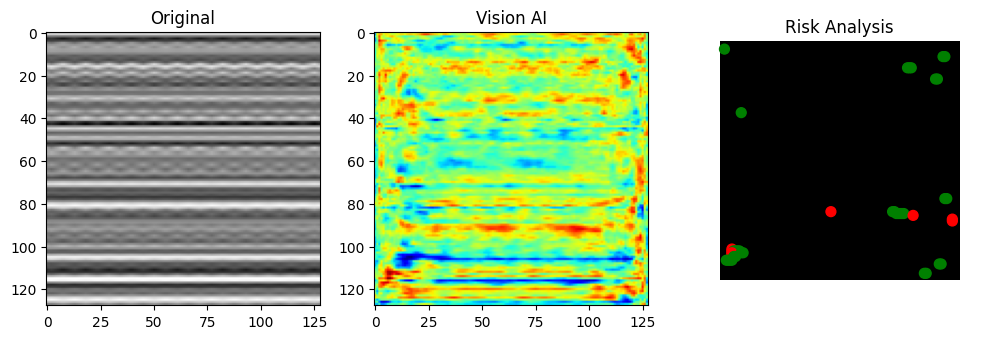

In [162]:

# FINAL INFERENCE

try:
    slice_idx = 76
    print(f"\nDIAGNOSING SLICE {slice_idx}...")
    
    sample = dataset[slice_idx]
    
    if sample['image'].max() == 0:
        print("Image is empty (all zeros)")

    img_tensor = sample['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits, _ = vision_model(img_tensor)
        pred_prob = torch.sigmoid(logits).squeeze().cpu().numpy()
    
    # Threshold > 0.6
    geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.75, is_simulation=False)
    
    if geo_data:
        geo_data = geo_data.to(device)
        risk_model.eval()
        with torch.no_grad():
            logits = risk_model(geo_data)
            preds = logits.argmax(dim=1).cpu().numpy()
        
        print(f"Found {len(preds)} nodes. {sum(preds)} are HIGH RISK.")
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(sample['image'].squeeze(), cmap='gray'); plt.title("Original")
        plt.subplot(1, 3, 2); plt.imshow(pred_prob, cmap='jet'); plt.title("Vision AI")
        plt.subplot(1, 3, 3); plt.imshow(np.zeros_like(pred_prob), cmap='gray') 
        pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
        colors = ['red' if p==1 else 'green' for p in preds]
        nx.draw(G_pruned, pos, node_size=50, node_color=colors, edge_color='white')
        plt.title("Risk Analysis")
        plt.show()
    else:
        print("No graph built (No faults found).")

except Exception as e:
    print(f"Error: {e}")

In [148]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch_geometric.nn import GATConv
# from torch_geometric.data import Data
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx
# from skimage.morphology import skeletonize
# import torch
# import numpy as np
# import random


# class FaultGAT(nn.Module):
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super(FaultGAT, self).__init__()
#         # Heads=4 means it learns 4 different ways to look at neighbors(depth continuity,dip continuity,branch intersections,fault segmentation code)
#         # [N_nodes, hidden_channels * 4]
#         self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.6)
#         # Output layer
#         self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.6)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         return F.log_softmax(self.conv2(x, edge_index), dim=1)


# # bridge between computer vision and graph leaarning
# def image_to_graph_pipeline(binary_mask, is_simulation=False):
#     skeleton = skeletonize(binary_mask) # convert thick fault region to 1 pixel centerlines
#     if np.sum(skeleton) == 0: return None, None
    
#     G_topo, G_vis = build_topology_from_skeleton(skeleton)
#     # each skeleton pixel -> node , nearby pixels -> edges
    
    
#     if not is_simulation:
#         # Assuming you have those helper functions defined elsewhere. 
#         # If not, we can simplify this line.
#         try:
#             G_pruned, _ = prune_spurious_branches(G_topo.copy(), min_length=10)
#         except:
#             G_pruned = G_topo.copy() # Fallback if pruning function is missing
#     else:
#         G_pruned = G_topo.copy() 
    
#     if G_pruned.number_of_nodes() < 2: return None, None

#     node_features = []
#     center_r, center_c = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2
    
#     for node in G_pruned.nodes():
#         r, c = node
#         # Feature A: Depth(deeper fault -> higher risk )
#         depth_norm = r / 128.0
        
#         # Feature B: Dip (vertical fault are dangerous)
#         is_vertical = False
#         neighbors = list(G_pruned.neighbors(node))
#         if len(neighbors) == 0:
#             is_vertical = True 
#         else:
#             for n in neighbors:
#                 r_n, c_n = n
#                 if abs(r - r_n) > abs(c - c_n): 
#                     is_vertical = True
#                     break
        
#         dip_norm = 1.0 if is_vertical else 0.1 
        
#         # Feature C: Amplitude
#         dist = np.sqrt((r - center_r)**2 + (c - center_c)**2)
#         amp_norm = max(0.1, 1.0 - (dist / 100.0))
        
#         node_features.append([depth_norm, dip_norm, amp_norm])
        
#     x = torch.tensor(node_features, dtype=torch.float)
    
#     edge_index_list = []
#     node_list = list(G_pruned.nodes())
#     for u, v in G_pruned.edges():
#         u_idx, v_idx = node_list.index(u), node_list.index(v)
#         edge_index_list.extend([[u_idx, v_idx], [v_idx, u_idx]])
        
#     if not edge_index_list: return None, None
#     edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    
#     # Risk Logic
#     y_list = [1 if (f[0] > 0.2 and f[1] > 0.8) else 0 for f in node_features]
#     y = torch.tensor(y_list, dtype=torch.long)

#     return Data(x=x, edge_index=edge_index, y=y), G_pruned


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# sim_mask = np.zeros((128, 128), dtype=bool)
# sim_mask[20:110, 40] = 1   
# sim_mask[20:110, 90] = 1   
# sim_mask[30, 20:110] = 1   
# sim_mask[70, 20:110] = 1   
# sim_mask[100, 20:110] = 1  

# # Helper functions for topology (Placeholder if you don't have them)
# def build_topology_from_skeleton(skel):
#     pts = np.column_stack(np.where(skel > 0))
#     G = nx.Graph()
#     for p in pts: G.add_node(tuple(p), pos=(p[1], p[0]))
#     from scipy.spatial import KDTree
#     if len(pts) > 1:
#         tree = KDTree(pts)
#         pairs = tree.query_pairs(r=1.5)
#         for i,j in pairs: G.add_edge(tuple(pts[i]), tuple(pts[j]))
#     return G, None

# train_data, _ = image_to_graph_pipeline(sim_mask, is_simulation=True)
# train_data = train_data.to(device)

# class_weights = torch.tensor([1.0, 5.0]).to(device)
# risk_model = FaultGAT(3, 8, 2).to(device) # <--- NOW THIS WILL WORK
# optimizer = optim.Adam(risk_model.parameters(), lr=0.005)
# risk_model.train()

# for epoch in range(300):
#     optimizer.zero_grad()
#     out = risk_model(train_data)
#     loss = F.nll_loss(out, train_data.y, weight=class_weights)
#     loss.backward()
#     optimizer.step()

# print("Training Complete.")

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vision_model = SeismicAttentionUNet2D().to(device)


# # FINAL INFERENCE

# try:
#     slice_idx = 76
#     print(f"\nDIAGNOSING SLICE {slice_idx}...")
    
#     sample = dataset[slice_idx]
    
#     if sample['image'].max() == 0:
#         print("Image is empty (all zeros)")

#     img_tensor = sample['image'].unsqueeze(0).to(device)
    
#     with torch.no_grad():
#         logits, _ = vision_model(img_tensor)
#         pred_prob = torch.sigmoid(logits).squeeze().cpu().numpy()
    
#     # Threshold > 0.6
#     geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.75, is_simulation=False)
    
#     if geo_data:
#         geo_data = geo_data.to(device)
#         risk_model.eval()
#         with torch.no_grad():
#             logits = risk_model(geo_data)
#             preds = logits.argmax(dim=1).cpu().numpy()
        
#         print(f"Found {len(preds)} nodes. {sum(preds)} are HIGH RISK.")
        
#         plt.figure(figsize=(12, 4))
#         plt.subplot(1, 3, 1); plt.imshow(sample['image'].squeeze(), cmap='gray'); plt.title("Original")
#         plt.subplot(1, 3, 2); plt.imshow(pred_prob, cmap='jet'); plt.title("Vision AI")
#         plt.subplot(1, 3, 3); plt.imshow(np.zeros_like(pred_prob), cmap='gray') 
#         pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
#         colors = ['red' if p==1 else 'green' for p in preds]
#         nx.draw(G_pruned, pos, node_size=50, node_color=colors, edge_color='white')
#         plt.title("Risk Analysis")
#         plt.show()
#     else:
#         print("No graph built (No faults found).")

# except Exception as e:
#     print(f"Error: {e}")

In [151]:
# # FINAL INFERENCE

# try:
#     slice_idx = 76
#     print(f"\nDIAGNOSING SLICE {slice_idx}...")
    
#     sample = dataset[slice_idx]
    
#     if sample['image'].max() == 0:
#         print("Image is empty (all zeros)")

#     img_tensor = sample['image'].unsqueeze(0).to(device)
    
#     with torch.no_grad():
#         logits, _ = vision_model(img_tensor)
#         pred_prob = torch.sigmoid(logits).squeeze().cpu().numpy()
    
#     # Threshold > 0.6
#     geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.75, is_simulation=False)
    
#     if geo_data:
#         geo_data = geo_data.to(device)
#         risk_model.eval()
#         with torch.no_grad():
#             logits = risk_model(geo_data)
#             preds = logits.argmax(dim=1).cpu().numpy()
        
#         print(f"Found {len(preds)} nodes. {sum(preds)} are HIGH RISK.")
        
#         plt.figure(figsize=(12, 4))
#         plt.subplot(1, 3, 1); plt.imshow(sample['image'].squeeze(), cmap='gray'); plt.title("Original")
#         plt.subplot(1, 3, 2); plt.imshow(pred_prob, cmap='jet'); plt.title("Vision AI")
#         plt.subplot(1, 3, 3); plt.imshow(np.zeros_like(pred_prob), cmap='gray') 
#         pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
#         colors = ['red' if p==1 else 'green' for p in preds]
#         nx.draw(G_pruned, pos, node_size=50, node_color=colors, edge_color='white')
#         plt.title("Risk Analysis")
#         plt.show()
#     else:
#         print("No graph built (No faults found).")

# except Exception as e:
#     print(f"Error: {e}")